# Avalanche Data Project - Observations

## Introduction

The main idea of this project is to generate a well calibrated avalanche report based the observations of winter conditions typically performed by backcountry skiers and snowboarders, the local weather, and avalanche reports. These reports provide very valuable information for not only backcountry users but also highway management in mountainous terrain. Currently the reports are carried out by publically and government support. This avalanche project uses observations from the Utah Avalanche Center (UAC) Website (https://utahavalanchecenter.org) which hosts reports that cover the entire state. This document explains my thought process on  how to make a model for predicting the likelyhood of an avalanche based on previous day observations. 

In [1]:
import pandas as pd
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import datetime
import re
import time

#for the attempt at location data
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

pd.__version__

'1.5.3'

I got some good infor on converting html files into pandas dataframes from this article, https://towardsdatascience.com/how-to-get-tables-from-websites-into-pandas-dataframes-e82bd8a0ac59. `

## Collecting Observation Data

### Observations List

First we get a list of observations from the UAC's website before we draw out each avalanche/conditions observation and log that in a table of observations or catalog. Each observation in the catalog holds whatever data that observer reports (weather, tests, descriptions, avalanche, etc). First we need to extract a list of all the observations made on the site's observation site (https://utahavalanchecenter.org/observations).

In [2]:
avy_center_url = 'http://utahavalanchecenter.org'
observations_url = avy_center_url + '/observations'
page = requests.get(observations_url)
soup = BeautifulSoup(page.content, 'html.parser')
tbl = soup.find("table")
#print(tbl.dtype)
page_obs = pd.read_html(str(tbl),extract_links ='all')[0]
page_obs.head()

,"(Date, None)","(Region, None)","(, None)","(Observer, None)"
0,"(4/17/2023, None)","(Salt Lake, None)","(Avalanche: Big Cottonwood Canyon, /avalanche/...","(Rick S., None)"
1,"(4/16/2023, None)","(Moab, None)","(Avalanche: Moab, /avalanche/78568)","(M Beach, None)"
2,"(4/16/2023, None)","(Provo, None)","(Observation: American Fork, /observation/78559)","(Kelly, Miller, Wieringa, None)"
3,"(4/16/2023, None)","(Moab, None)","(Observation: Moab, /observation/78539)","(W Ambler and J Noteboom, None)"
4,"(4/16/2023, None)","(Provo, None)","(Observation: Cascade Ridge, /observation/78543)","(Dave Jarvis, None)"


The main problem with the extract_links is it converts everying into a tuple. We want to eliminate the tuples and rewrite the "(,None)" column as "link_extensions".

In [3]:
old_columns = page_obs.columns

In [4]:
#change names
page_obs[['Date', 'a']]= pd.DataFrame(page_obs[old_columns[0]].tolist(), index=page_obs.index)
page_obs[['Region', 'b']]= pd.DataFrame(page_obs[old_columns[1]].tolist(), index=page_obs.index) 
page_obs[['Observation Title', 'extension']]= pd.DataFrame(page_obs[old_columns[2]].tolist(), index=page_obs.index) 
page_obs[['Observer', 'd']]= pd.DataFrame(page_obs[old_columns[3]].tolist(), index=page_obs.index)

#remove old columns & columns with none
page_obs=page_obs.drop(old_columns, axis=1)
page_obs=page_obs.drop(['a','b','d'], axis=1)
page_obs.head()

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Provo,Observation: American Fork,/observation/78559,"Kelly, Miller, Wieringa"
3,4/16/2023,Moab,Observation: Moab,/observation/78539,W Ambler and J Noteboom
4,4/16/2023,Provo,Observation: Cascade Ridge,/observation/78543,Dave Jarvis


Lets wrap that all into some nice functions.

In [5]:
def get_page_obs(url):
    '''returns a dataframe of avalanche observations from url. Data in df
    includes Date, Region, Avalanche/Observation, (url) extension, and
    observor'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tbl=soup.find("table")
    page_obs = pd.read_html(str(tbl), extract_links='all')[0]
    page_obs = clean_page_obs(page_obs)
    return page_obs

def clean_page_obs(page_obs):
    '''Cleans up the html parser's interpretation of the observation list'''
    old_columns = page_obs.columns
    #change names 
    page_obs[['Date', 'a']]= pd.DataFrame(page_obs[old_columns[0]].tolist(), index=page_obs.index)
    page_obs[['Region', 'b']]= pd.DataFrame(page_obs[old_columns[1]].tolist(), index=page_obs.index)
    page_obs[['Observation Title', 'extension']]= pd.DataFrame(page_obs[old_columns[2]].tolist(), index=page_obs.index)
    page_obs[['Observer', 'd']]= pd.DataFrame(page_obs[old_columns[3]].tolist(), index=page_obs.index)
    #remove old columns & columns with none
    page_obs=page_obs.drop(old_columns, axis=1)
    page_obs=page_obs.drop(['a','b','d'], axis=1)
    return page_obs

page_obs = get_page_obs(observations_url)
page_obs.head()


,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Provo,Observation: American Fork,/observation/78559,"Kelly, Miller, Wieringa"
3,4/16/2023,Moab,Observation: Moab,/observation/78539,W Ambler and J Noteboom
4,4/16/2023,Provo,Observation: Cascade Ridge,/observation/78543,Dave Jarvis


Next lets try iterating through each of the pages. The starting page url is https://utahavalanchecenter.org/observations. When clicked on the next page we get https://utahavalanchecenter.org/observations?page=1. So lets just keep stepping up from there.

In [6]:
n_pages = 5
page_obs = pd.DataFrame()
entries_start= page_obs.shape
for page in range(n_pages):
    url = observations_url
    if page != 0:
        url = url + f"?page={page}"
    page_obs_new = get_page_obs(url)
    page_obs = pd.concat([page_obs, page_obs_new])
page_obs = page_obs.reset_index(drop=True)
entries_end = page_obs.shape
print('Entries started with', entries_start,'and ended with', entries_end)
print(page_obs.iloc[0])
print(page_obs.iloc[-1])

Entries started with (0, 0) and ended with (250, 5)
Date                                        4/17/2023
Region                                      Salt Lake
Observation Title    Avalanche: Big Cottonwood Canyon
extension                            /avalanche/78571
Observer                                      Rick S.
Name: 0, dtype: object
Date                                3/28/2023
Region                              Salt Lake
Observation Title    Observation: Patsy Marly
extension                  /observation/77561
Observer                               Harold
Name: 249, dtype: object


In [7]:
page_obs

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Provo,Observation: American Fork,/observation/78559,"Kelly, Miller, Wieringa"
3,4/16/2023,Moab,Observation: Moab,/observation/78539,W Ambler and J Noteboom
4,4/16/2023,Provo,Observation: Cascade Ridge,/observation/78543,Dave Jarvis
...,...,...,...,...,...
245,3/29/2023,Salt Lake,Observation: Mt Olympus,/observation/77569,DB
246,3/28/2023,Ogden,Accident: Morgan,/avalanche/77530,UAC Staff
247,3/28/2023,Salt Lake,Avalanche: Mineral Fork,/avalanche/77504,Chester
248,3/28/2023,Salt Lake,Observation: Mill Creek Canyon,/observation/77567,Kirsten Weinbrom


#### Custom Date Range
Utah Avalanche also allows for you to look back into past season's avalanches using the custom date range. Given the range from 01/01/2021 to 12/01/2021 the output url is: https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021.

In [8]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 1, 1)
print(end_date-start_date)
print(type(start_date))

365 days, 0:00:00
<class 'datetime.datetime'>


In [9]:
def generate_url(start_date, end_date):
    return f"https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D={start_date.month:02d}/{start_date.day:02d}/{start_date.year}&fodv%5Bmax%5D%5Bdate%5D={end_date.month:02d}/{end_date.day:02d}/{end_date.year}"
    
gen_url=generate_url(start_date = datetime.datetime(2021,1,1), end_date = datetime.datetime(2021, 12,1))
if gen_url == 'https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021':
    print('The urls match:', gen_url)
else:
    print('The urls failed:')
    print(gen_url)
    print('https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021')

The urls match: https://utahavalanchecenter.org/observations?rid=All&term=All&fodv%5Bmin%5D%5Bdate%5D=01/01/2021&fodv%5Bmax%5D%5Bdate%5D=12/01/2021


For a large enough range there will be multiple pages and we will need to iterate through those. To step through the pages we just need to add the string '&page=page_num' to the generated url where page_num is the page number.

In [10]:
#collect the reports from December 2022. 
start_date = datetime.datetime(2022, 12,1)
end_date = datetime.datetime(2022, 12, 31)
start_url = generate_url(start_date, end_date)
page_num = 0
observations = pd.DataFrame()
while True:
    try:
        if page_num != 0:
            data_url = start_url + f"&page={page_num}"
        else:
            data_url = start_url
        page_obs_new = get_page_obs(data_url)
        observations = pd.concat([observations, page_obs_new])
        page_num += 1
    except:
        break
observations = observations.reset_index(drop=True)
observations

,Date,Region,Observation Title,extension,Observer
0,12/31/2022,Ogden,Avalanche: Rodeo Ridge,/avalanche/72835,Bill Brandt
1,12/31/2022,Ogden,Avalanche: Cutler Basin,/avalanche/72774,Joe
2,12/31/2022,Logan,Observation: Beaver Mountain Backcountry,/observation/72698,"weed, pagnucco"
3,12/31/2022,Salt Lake,Avalanche: Willows,/avalanche/72713,McKay
4,12/31/2022,Provo,Avalanche: North Fork Provo R.,/avalanche/72726,
...,...,...,...,...,...
519,12/1/2022,Provo,Observation: Provo,/observation/70921,Susan S
520,12/1/2022,Salt Lake,Observation: Brighton Perimeter,/observation/70924,"Talty, Coyne, Gill"
521,12/1/2022,Salt Lake,Observation: West ridge,/observation/70928,"Will Ambler, Will Marin"
522,12/1/2022,Salt Lake,Avalanche: Mineral Fork,/avalanche/70931,Julian Kallanian


In [11]:
#lets put that in a function
def get_obs(start_date, end_date):
    '''returns a dataframe of the observations on the UAC website. '''
    start_url = generate_url(start_date, end_date)
    page_num = 0
    observations = pd.DataFrame()
    while True:
        try:
            if page_num != 0:
                data_url = start_url + f"&page={page_num}"
            else:
                data_url = start_url
            page_obs_new = get_page_obs(data_url)
            observations = pd.concat([observations, page_obs_new])
            page_num += 1
        except:
            #if the page can't be loaded then we've reached the end of available obs
            break
    observations = observations.reset_index(drop=True)
    #TODO: if no start date or end date give this season's observations
    return observations

#### Season Data
In general a ski season in the Wasatch typically lasts from the late fall (October or November) to mid spring (April or May). Therefore we can define a season easily between the dry months of July and August. If we wanted to collect the data from the current season we need only to look between "today" and the beginning of that season. 

In [12]:
today = datetime.date.today()
print(today, type(today))
def get_season_start(date):
    '''returns the beginning of the season as defined between the last August and the end of July'''
    start_day = 1
    start_month = 8
    end_month = 7
    if date.month < 7:
        start_year = date.year-1
    else:
        start_year = date.year
    return datetime.datetime(start_year, start_month, start_day)
print(get_season_start(today))

2023-04-18 <class 'datetime.date'>
2022-08-01 00:00:00


In [13]:
def get_season_obs(date = datetime.date.today()):
    '''fetches the observations of the season for the date specified'''
    season_start = get_season_start(date)
    return get_obs(season_start, date)
season_obs = get_season_obs()
season_obs

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Provo,Observation: American Fork,/observation/78559,"Kelly, Miller, Wieringa"
3,4/16/2023,Moab,Observation: Moab,/observation/78539,W Ambler and J Noteboom
4,4/16/2023,Provo,Observation: Cascade Ridge,/observation/78543,Dave Jarvis
...,...,...,...,...,...
2339,10/24/2022,Salt Lake,Observation: Little Cottonwood Canyon,/observation/69799,
2340,10/23/2022,Salt Lake,Avalanche: High Greeley,/avalanche/69798,Nate Fillnow
2341,10/23/2022,Salt Lake,Avalanche: Cardiac Ridge,/avalanche/69797,UAC Staff
2342,10/23/2022,Salt Lake,Avalanche: Baldy,/avalanche/69788,UAC Staff - Meisenheimer


### Sorting Observations
Filtering for regions, avalanches vs observations, and others. 

In [14]:
season_obs.shape[0]

2344

#### Filter Regions

In [15]:
#What are the avalanche regions that got avalanches this season?
print(season_obs.Region.value_counts())

Salt Lake     1136
Logan          352
Ogden          227
Provo          218
Uintas         206
Moab           112
Skyline         54
Southwest       22
Abajos          11
SE Idaho         5
State-wide       1
Name: Region, dtype: int64


In [16]:
#This season I'm generally staying in the Salt Lake region of the Wasatch
saltLake_obs = season_obs.loc[season_obs.Region == "Salt Lake"]
saltLake_obs

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
5,4/16/2023,Salt Lake,Observation: Mill D North,/observation/78542,Michael B
9,4/16/2023,Salt Lake,Observation: Mill D North,/observation/78536,Gagne
15,4/15/2023,Salt Lake,Observation: Broads Fork,/observation/78494,Andy
17,4/14/2023,Salt Lake,Observation: Mill A,/observation/78487,J. Wright
...,...,...,...,...,...
2339,10/24/2022,Salt Lake,Observation: Little Cottonwood Canyon,/observation/69799,
2340,10/23/2022,Salt Lake,Avalanche: High Greeley,/avalanche/69798,Nate Fillnow
2341,10/23/2022,Salt Lake,Avalanche: Cardiac Ridge,/avalanche/69797,UAC Staff
2342,10/23/2022,Salt Lake,Avalanche: Baldy,/avalanche/69788,UAC Staff - Meisenheimer


#### Filter Avalanche vs Observation

In [17]:
season_obs['Observation Title'].str.split(':').str[0]

0         Avalanche
1         Avalanche
2       Observation
3       Observation
4       Observation
           ...     
2339    Observation
2340      Avalanche
2341      Avalanche
2342      Avalanche
2343    Observation
Name: Observation Title, Length: 2344, dtype: object

In [18]:
def filter_avalanche(observations):
    '''filters pandas dataframe for just avalanche entries'''
    return observations.loc[observations['Observation Title'].str.split(':').str[0] == 'Avalanche']
    
season_avys = filter_avalanche(season_obs)
print(season_avys)

            Date     Region                 Observation Title  \
0      4/17/2023  Salt Lake  Avalanche: Big Cottonwood Canyon   
1      4/16/2023       Moab                   Avalanche: Moab   
6      4/16/2023      Ogden          Avalanche: Taylor Canyon   
7      4/16/2023      Ogden           Avalanche: Black Canyon   
8      4/16/2023      Ogden           Avalanche: Willard Peak   
...          ...        ...                               ...   
2323   11/2/2022  Salt Lake     Avalanche: Upper Collins area   
2335  10/25/2022       Moab       Avalanche: Gravel Pit Lanes   
2340  10/23/2022  Salt Lake           Avalanche: High Greeley   
2341  10/23/2022  Salt Lake          Avalanche: Cardiac Ridge   
2342  10/23/2022  Salt Lake                  Avalanche: Baldy   

             extension                  Observer  
0     /avalanche/78571                   Rick S.  
1     /avalanche/78568                   M Beach  
6     /avalanche/78541             Derek DeBruin  
7     /avalanch

In [19]:
def filter_general_observations(observations):
    '''filters pandas dataframe for just general observation entries'''
    return observations.loc[observations['Observation Title'].str.split(':').str[0] == 'Observation']
    
season_genobs = filter_general_observations(season_obs)
print(season_genobs)

            Date     Region                      Observation Title  \
2      4/16/2023      Provo             Observation: American Fork   
3      4/16/2023       Moab                      Observation: Moab   
4      4/16/2023      Provo             Observation: Cascade Ridge   
5      4/16/2023  Salt Lake              Observation: Mill D North   
9      4/16/2023  Salt Lake              Observation: Mill D North   
...          ...        ...                                    ...   
2336  10/25/2022  Salt Lake            Observation: Peruvian Ridge   
2337  10/24/2022  Salt Lake             Observation: Alta Ski Area   
2338  10/24/2022       Moab                      Observation: Moab   
2339  10/24/2022  Salt Lake  Observation: Little Cottonwood Canyon   
2343  10/22/2022  Salt Lake               Observation: Emma Ridges   

               extension                 Observer  
2     /observation/78559  Kelly, Miller, Wieringa  
3     /observation/78539  W Ambler and J Noteboom  
4  

### Avalanche and Observation Data

This looks great! Now let's try inspecting the extension and try extracting information from the observation table. Avalanche and General Observations are useful for tracking avalanches and conditions that could potentially result in avalanches. These observations are stuctured differently on the website, let's look at those differences.

#### Avalanche Observations
- Name
- Email
- Obs Date
- Avy Date
- Location (Region, Name/Route, Lat/Long?)
- Elevation
- Aspect
- Trigger (natural or skier)
- Depth
- Width
- Carried
- Snow Profile
- Comments

There seems to be some similarities and differences. As I parse through the various Reports I will first focus on the avalanche attributes. Lets start with just Observation Title, Observor Name, Observation Date, Location, Observation or Avalanche and Comments.

##### Web Scraping

In [20]:
page_avys = filter_avalanche(page_obs).reset_index()
page_avys.head()

,index,Date,Region,Observation Title,extension,Observer
0,0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,6,4/16/2023,Ogden,Avalanche: Taylor Canyon,/avalanche/78541,Derek DeBruin
3,7,4/16/2023,Ogden,Avalanche: Black Canyon,/avalanche/78540,Derek DeBruin
4,8,4/16/2023,Ogden,Avalanche: Willard Peak,/avalanche/78538,Derek DeBruin


In [21]:
extension = page_avys.loc[0, 'extension']
print(avy_center_url+extension)
page = requests.get(avy_center_url + extension)
soup = BeautifulSoup(page.content, 'html.parser')

http://utahavalanchecenter.org/avalanche/78571


In [22]:
title_class='page-title'
fields = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route', 'Snow Profile','Comments']
observation_title = soup.find(class_='page-title').string
print('Observation title is:', observation_title)

for field in fields:
    try:
        datum = soup.find(string=field).parent.next_sibling.next_sibling.string
    except:
        datum = None
    print(field, 'is:',datum)

Observation title is: Avalanche: Big Cottonwood Canyon
Observer Name is: Rick S.
Observation Date is: Monday, April 17, 2023
Region is: Salt Lake » Big Cottonwood Canyon
Location Name or Route is: Near Laurel Pines, just below the Butler Fork Trailhead
Snow Profile is: None
Comments is: None


Observations generally have more complex data with a Weather section, Red Flags, Avalanche Problem, etc. So lets try and extract all the info we can from an a report ONLY if it's an avalanche report

##### Location Data

Now I will collect location data from the avalance observation.

##### Numeric Data
Currently all the numerical data is listed as strings where Elevation is for example "8,500'" when we really want an elevation category in feet with a numerical value as the entry. To solve this we will use regular expressions.

In [23]:
r = re.compile(r"([0-9]*),([0-9]*)'")
m = r.match("130,000'")
print(int(m.group(1))*1000+ int(m.group(2)))

130000


In [24]:
r = re.compile(r"([0-9]*)\"")
m = r.match("40\"")
print(float(m.group(1)))

40.0


In [25]:
r = re.compile(r"([0-9]*)°")
m = r.match("37°")
print(float(m.group(1)))

37.0


In [26]:
#here are all the fields that we have
re_units = {}
re_units['Elevation']=re.compile(r"([0-9]*),([0-9]*)'")
re_units['"'] = re.compile(r"([0-9]*|[0-9]*.[0-9]*)\"")
re_units['\''] = re.compile(r"([0-9]*|[0-9]*.[0-9]*)\'")
re_units['°'] = re.compile(r"([0-9]*)°")

field_units = {}
field_units['Elevation'] = "\'"
field_units['Depth'] = "\""
field_units['Width'] = "\'"
field_units['Slope Angle'] = "°"
field_units['New Snow Depth'] = "\""

def convert_to_inches(l_feet):
    '''converts the length in feet to inches'''
    return l_feet*12

def convert_to_numeric(raw_string, field):
    unit = raw_string[-1]
    #print(unit)
    field_unit = field_units[field]
    #print(field_unit)
    if unit != field_unit:
        raw_string = re.sub(unit, field_unit, raw_string)
    #print(raw_string)
    
    if field == 'Elevation':
        r = re_units['Elevation']
        m = r.match(raw_string)
        num = float(m.group(1))*1000 + float(m.group(2))
    else:
        r = re_units[field_unit]
        m = r.match(raw_string)
        num = float(m.group(1))
    #unit is given in ' and should be "
    if unit != field_unit:
        num = convert_to_inches(num)
    return num

def test_re():
    elevation = "15,567'"
    depth = "18\""
    width = "5'"
    angle = "37°"
    snow_depth1 = "2.5'"
    snow_depth2 = "2.5\""
    num_elevation = convert_to_numeric(elevation, 'Elevation')
    num_depth = convert_to_numeric(depth, 'Depth')
    num_width = convert_to_numeric(width, 'Width')
    num_angle = convert_to_numeric(angle, 'Slope Angle')
    num_snow_depth1= convert_to_numeric(snow_depth1, 'New Snow Depth')
    num_snow_depth2= convert_to_numeric(snow_depth2, 'New Snow Depth')
    print('Test elevation:', elevation, '->', num_elevation)
    print('Test depth:', depth, '->', num_depth)
    print('Test width:', width, '->', num_width)
    print('Test angle:', angle, '->', num_angle)
    print('Test snow depth:', snow_depth1, '->', num_snow_depth1)
    print('Test snow depth:', snow_depth2, '->', num_snow_depth2)
    return

test_re()

Test elevation: 15,567' -> 15567.0
Test depth: 18" -> 18.0
Test width: 5' -> 5.0
Test angle: 37° -> 37.0
Test snow depth: 2.5' -> 30.0
Test snow depth: 2.5" -> 2.5


In [27]:
def get_avalanche_data(url, verbose = False):
    '''Extracts avalanche data from avalanche reports'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    fields = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route', 'Snow Profile','Comments']
    avy_fields = ['Elevation', 'Aspect', 'Trigger', 'Depth', 'Width', 'Carried']
    numeric_fields = ['Elevation', 'Depth', 'Width']
    avalanche_data = {}
    observation_title = soup.find(class_='page-title').string
    if observation_title.split(':')[0] == 'Avalanche':
        fields = fields + avy_fields
        for field in fields:
            try:
                datum = soup.find(string=field).parent.next_sibling.next_sibling.string
                if field in numeric_fields:
                    datum = convert_to_numeric(datum, field)
            except:
                datum = None
                
            if verbose:
                print(field, 'is:',datum)
            avalanche_data[field] = datum
    return avalanche_data

In [28]:
extension = page_avys.loc[0, 'extension']
print(avy_center_url+extension)
get_avalanche_data(avy_center_url + extension, verbose=True)

http://utahavalanchecenter.org/avalanche/78571
Observer Name is: Rick S.
Observation Date is: Monday, April 17, 2023
Region is: Salt Lake » Big Cottonwood Canyon
Location Name or Route is: Near Laurel Pines, just below the Butler Fork Trailhead
Snow Profile is: None
Comments is: None
Elevation is: 7400.0
Aspect is: South
Trigger is: Natural
Depth is: None
Width is: None
Carried is: None


{'Observer Name': 'Rick S.',
 'Observation Date': 'Monday, April 17, 2023',
 'Region': 'Salt Lake » Big Cottonwood Canyon',
 'Location Name or Route': 'Near Laurel Pines, just below the Butler Fork Trailhead',
 'Snow Profile': None,
 'Comments': None,
 'Elevation': 7400.0,
 'Aspect': 'South',
 'Trigger': 'Natural',
 'Depth': None,
 'Width': None,
 'Carried': None}

##### Compiling Avalanche Data
Now we want to compile data from multiple reports. Lets first start by compiling JUST avalanches from this season. We sorted these out earlier. In the end we want to have a data table with each avalanche observation from the list of observations requested. 

In [29]:
season_obs = get_season_obs()
season_avys = filter_avalanche(season_obs).reset_index(drop=True)
season_avys.head()

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Ogden,Avalanche: Taylor Canyon,/avalanche/78541,Derek DeBruin
3,4/16/2023,Ogden,Avalanche: Black Canyon,/avalanche/78540,Derek DeBruin
4,4/16/2023,Ogden,Avalanche: Willard Peak,/avalanche/78538,Derek DeBruin


In [30]:
extensions = list(season_avys.extension)
data = []
err = []
for extension in extensions:
    try:
        new_data = get_avalanche_data(avy_center_url+extension)
        data.append(new_data)
    except:
        err.append(extension)
avy_data = pd.DataFrame(data)
avy_data.head()

,Observer Name,Observation Date,Region,Location Name or Route,Snow Profile,Comments,Elevation,Aspect,Trigger,Depth,Width,Carried
0,Rick S.,"Monday, April 17, 2023",Salt Lake » Big Cottonwood Canyon,"Near Laurel Pines, just below the Butler Fork ...",None,None,7400.0,South,Natural,NaN,NaN,None
1,M Beach,"Sunday, April 16, 2023",Moab,Haystack,None,D1 avalanche slowly slid on dust layer. Occurr...,10500.0,Southeast,Skier,4.0,30.0,None
2,Derek DeBruin,"Sunday, April 16, 2023",Ogden » Snowbasin Backcountry » Taylor Canyon,"Mount Ogden, Taylor Canyon, The Burn",None,None,7400.0,Northwest,Natural,NaN,NaN,None
3,Derek DeBruin,"Sunday, April 16, 2023",Ogden » Ben Lomond » Black Canyon,"Ben Lomond, Black Canyon",None,A large glide crack has formed beneath the upp...,8400.0,Southeast,Natural,NaN,5.0,None
4,Derek DeBruin,"Sunday, April 16, 2023",Ogden » Willard Peak,Willard Peak,None,There are a series of glide cracks forming alo...,9000.0,South,Natural,NaN,NaN,None


In [31]:
print(err)

[]


##### Data Summary
Now we can finally look at some stats from this season

In [32]:
#which aspects are there more avalanches?
avy_data.Aspect.value_counts()

Northeast    273
East         255
North        211
Southeast     96
Northwest     88
South         80
West          70
Southwest     36
Name: Aspect, dtype: int64

<AxesSubplot:>

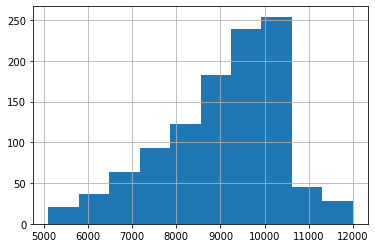

In [33]:
#how does avalanche likelyhood increase with elevation?
avy_data.Elevation.hist()

<AxesSubplot:>

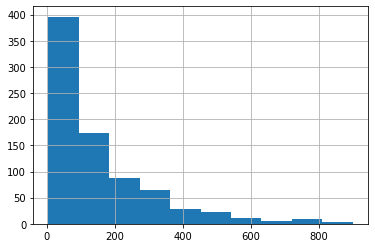

In [34]:
#what is the width of avalanches
avy_data.Width.hist()

<AxesSubplot:>

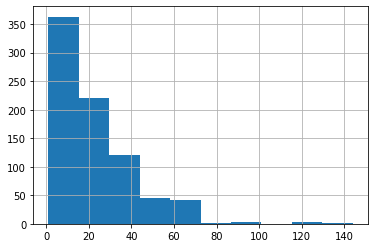

In [35]:
#what are the depths of avalanches this season
avy_data.Depth.hist()

In [36]:
#who observed the most avalanches
avy_data['Observer Name'].value_counts().head(20)

weed              61
Trenbeath         21
Bill Nalli        16
Brett Kobernik    13
B                 13
Toby Weed         12
Derek DeBruin     10
UAC Staff         10
Dave Jarvis       10
Weed               9
Torrey             8
UAC Staff          8
Staples et al      8
weed, pagnucco     8
CB                 7
Bill Brandt        7
Chris Benson       7
Pagnucco           6
Wolford            6
Staples            6
Name: Observer Name, dtype: int64

<AxesSubplot:>

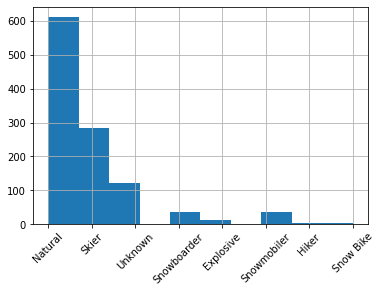

In [37]:
#What triggered these avalanches
avy_data['Trigger'].hist(xrot=45)

<AxesSubplot:>

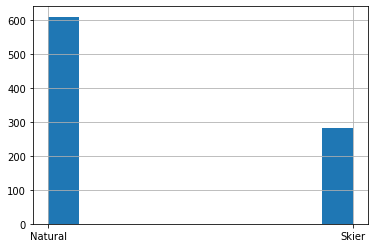

In [38]:
#closer look at Skier vs natural avalanches.
avy_data[avy_data['Trigger'].isin(['Skier', 'Natural'])]['Trigger'].hist()

In [39]:
# Out of the avalanches how many are carried
n_carried = avy_data['Carried'].value_counts().sum()
n_avalanches = avy_data.shape[0]
print(f"Out of {n_avalanches} reported avalanches, there were {n_carried} people caught and carried.")

# How many skier triggered avalanches result in a person being carried. 
skier_triggered = avy_data[avy_data['Trigger'] == 'Skier'].shape[0]
skier_triggered_carried = avy_data[avy_data['Trigger'] == 'Skier']['Carried'].value_counts().sum()
print(f"Out of {skier_triggered} skier triggered avalanches, {skier_triggered_carried} of those skiers were carried by an avalanche.")

Out of 1132 reported avalanches, there were 61 people caught and carried.
Out of 284 skier triggered avalanches, 41 of those skiers were carried by an avalanche.


#### General Observations
- Name
- Email
- Obs Date
- Location
- Weather
- Red Flags
- Avalanche Problem #1
- Avalanche Problem #2
- Snow Profile
- Comments

Observations generally have more complex data with a Weather section, Red Flags, Avalanche Problem, etc. So lets try and extract all the info we can from an a report ONLY if it's an avalanche report

##### Web Scraping

In [40]:
page_gen_obs = filter_general_observations(page_obs).reset_index()
#this observation is a good example since it contains all availible entries
extension = '/observation/77559'
print('We will look at', avy_center_url+extension)

We will look at http://utahavalanchecenter.org/observation/77559


A key difference between the html structure of observations vs avalanches are the various groups of data:
- weather
- snow characteristics
- red flags
- avy problems (usually 0-2)
- snow profile

Aside from these we still have some of the same fields from avalanches
- oberver name
- observation date
- region
- location name or route
- comments

In [41]:
page = requests.get(avy_center_url + extension)
soup = BeautifulSoup(page.content, 'html.parser')


title_class='page-title'
fields = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route', 'Snow Profile','Comments']
observation_title = soup.find(class_='page-title').string
print('Observation title is:', observation_title)

for field in fields:
    try:
        datum = soup.find(string=field).parent.next_sibling.next_sibling.string
    except:
        datum = None
    print(field, 'is:',datum)

Observation title is: Observation: Tony Grove Area
Observer Name is: Weed
Observation Date is: 3/28/2023
Region is: Logan » Logan River » Tony Grove Area
Location Name or Route is: Tony Grove Lake Area
Snow Profile is: None
Comments is: There is around 12' of snow on the ground around Tony Grove Lake. Huge and dangerous overhanging cornices are found on the upper elevation ridges. 


That code works fine! Now lets look at the groups each group contains the same html labels that we used for scraping the avalanche data. Lets make a function to pick apart each group and then nest in the same code we had to scrape the fields and field data.

In [42]:
#First lets make a dictionary with each of the observations 
fields_dict = {} #group: [list of fields]
fields_dict['General'] = ['Observer Name', 'Observation Date', 'Region', 'Location Name or Route','Comments']
fields_dict['Weather'] = ['Sky', 'Wind Direction', 'Wind Speed', 'Weather Comments']
# "Snow surface conditions" may have multiple entries
fields_dict['Snow Characteristics'] = ['New Snow Depth', 'New Snow Density', 'Snow Surface Conditions', 'Snow Characteristics Comments'] 
# "Red Flags" may have multiple entries
fields_dict['Red Flags']=['Red Flags', 'Red Flags Comments']
fields_dict['Avalanche Problem #1'] = ['Problem', 'Trend', 'Problem #1 Comments']
fields_dict['Avalanche Problem #2'] = ['Problem', 'Trend', 'Problem #2 Comments']
#containts image
fields_dict['Snow Profile'] = ['Aspect', 'Elevation', 'Slope Angle']

multi_entry_fields = ['Red Flags', 'Snow Surface Conditions']

As we can see there are a few fields with potential multiple entries. For these we will need to keep checking and also there is an image of a snow profile which is stored on a url. It might be useful to scrape that too.

In [43]:
#a useful function
def read_multiple_entries(field, soup):
    '''returns a list of field of entries for a multi-entry field such as Red Flags and Snow Surface Conditions'''
    if field == 'Red Flags':
        parent_soup = soup.find_all(string=field)[1].parent
    else:
        parent_soup = soup.find(string=field).parent
    current_entry = parent_soup.next_sibling.next_sibling
    
    field_entries = []
    read_entries = True
    while read_entries:
        #print(current_entry)
        field_entries.append(current_entry.string)
        current_entry = current_entry.next_sibling.next_sibling
        #check to see if we ran into comments commonly found below a field
        if len(current_entry.string) > 20:
            read_entries = False
    return field_entries

def read_field_entry(field, soup):
    '''read the field entry for the given observation soup'''
    try:
        field_entry = soup.find(string=field).parent.next_sibling.next_sibling.string
    except:
        field_entry = None
        #print("Error at field:", field)
    #if field in numeric_fields:
            #field_entry = convert_to_numeric(field_entry, field)
            #TODO:fix slope angle and numeric fields
    return field_entry

def read_general_observation(url, verbose = False):
    '''Extracts avalanche data from avalanche reports'''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    numeric_fields = ['Elevation', 'Slope Angle']
    multi_entry_fields = ['Red Flags', 'Snow Surface Conditions']
    
    observation_data = {}
    #get observation title
    title_class='page-title'
    observation_title = soup.find(class_='page-title').string
    observation_data['Observation Title'] = observation_title
    if verbose:
        print(observation_title, url)
    

    field_groups = list(fields_dict.keys())
    for group in field_groups:
        if verbose:
            print('\n',group,'Group:')
        for field in fields_dict[group]:
            if field in multi_entry_fields:
                entry = read_multiple_entries(field, soup)
            #TODO: extract image url from snow profile
            else:
                entry = read_field_entry(field, soup)
            if verbose:
                    print(field, ':',entry)
            observation_data[field] = entry
    return observation_data

gen_obs_data = read_general_observation(avy_center_url + extension, verbose=True)
print('\n',gen_obs_data)

Observation: Tony Grove Area http://utahavalanchecenter.org/observation/77559

 General Group:
Observer Name : Weed
Observation Date : 3/28/2023
Region : Logan » Logan River » Tony Grove Area
Location Name or Route : Tony Grove Lake Area
Comments : There is around 12' of snow on the ground around Tony Grove Lake. Huge and dangerous overhanging cornices are found on the upper elevation ridges. 

 Weather Group:
Sky : Few
Wind Direction : South
Wind Speed : Strong
Weather Comments : A nice warm day....windy in exposed terrain

 Snow Characteristics Group:
New Snow Depth : 2.5'
New Snow Density : Medium
Snow Surface Conditions : ['Powder', 'Melt-Freeze Crust']
Snow Characteristics Comments : Nice powder conditions, especially in shady terrain. Wind affected in exposed terrain and sun affected on slopes facing south half of compass 

 Red Flags Group:
Red Flags : ['Wind Loading']
Red Flags Comments : No sign of recent activity (since the weekend storm) except a few small cornice falls and 

##### Compiling General Observation Data

In [44]:
season_obs.head()

,Date,Region,Observation Title,extension,Observer
0,4/17/2023,Salt Lake,Avalanche: Big Cottonwood Canyon,/avalanche/78571,Rick S.
1,4/16/2023,Moab,Avalanche: Moab,/avalanche/78568,M Beach
2,4/16/2023,Provo,Observation: American Fork,/observation/78559,"Kelly, Miller, Wieringa"
3,4/16/2023,Moab,Observation: Moab,/observation/78539,W Ambler and J Noteboom
4,4/16/2023,Provo,Observation: Cascade Ridge,/observation/78543,Dave Jarvis


In [45]:
def get_observation_data(observation_table):
    '''Takes a dataframe containing a list of links to general observations and returns
    the data from each of those observations in a dataframe'''
    general_observation_table = filter_general_observations(observation_table).reset_index(drop=True)
    extensions = list(general_observation_table.extension)
    print('Gathering Data from', len(extensions), 'general observations...')
    data = []
    err = [] #collect list of extensions that did not work
    for extension in extensions:
        try:
            new_data = read_general_observation(avy_center_url + extension)
            data.append(new_data)
        except:
            err.append(extension)
    gen_obs_data = pd.DataFrame(data)
    return gen_obs_data, err

gen_obs, err = get_observation_data(season_obs)
gen_obs.head()

Gathering Data from 1201 general observations...


,Observation Title,Observer Name,Observation Date,Region,Location Name or Route,Comments,Sky,Wind Direction,Wind Speed,Weather Comments,...,Snow Characteristics Comments,Red Flags,Red Flags Comments,Problem,Trend,Problem #1 Comments,Problem #2 Comments,Aspect,Elevation,Slope Angle
0,Observation: Moab,W Ambler and J Noteboom,4/16/2023,Moab,Mellenthin,Pictured below are some beautiful striations c...,Clear,None,None,None,...,In terrain which has been sheltered from both ...,"[Wind Loading, Rapid Warming]",No significant avalanche activity was noted to...,None,None,None,None,None,None,None
1,Observation: Tibble Fork,"Kelly, Williams",4/15/2023,Provo » American Fork » Tibble Fork,Tibble Fork,None,Clear,Northwest,Light,Clear skies with light northwest winds. Winds ...,...,None,"[Recent Avalanches, Rapid Warming]",There were signs of recent wet loose avalanche...,Wet Snow,Same,None,We saw evidence of massive cornices on the rid...,None,None,None
2,Observation: Upper Weber Canyon,Craig Gordon/Trevor Katz,4/6/2023,Uintas » Upper Weber Canyon,Upper Weber/Upper Moffit Basin,None,Clear,Southwest,Light,"Stunning day... clear skies, crisp AM temps, a...",...,None,[Rapid Warming],"Checked rapid warming, but it really wasn't th...",Wind Drifted Snow,Decreasing Danger,None,None,None,None,None
3,Observation: Tony Grove Lake,"weed, pagnucco",4/6/2023,Logan » Logan River » Tony Grove » Tony Grove ...,Tony Grove Lake Area,None,Clear,South,Light,First bluebird pow day in a little while,...,Deep! Trenching while breaking trail. We found...,"[Recent Avalanches, Rapid Warming]",Dangerous conditions so we stayed off and out ...,Cornice,Increasing Danger,We stayed well away and out from under these m...,None,None,None,None
4,Observation: Raymond Glade,Hardesty and Wilson,4/6/2023,Salt Lake » Mill Creek Canyon » Porter Fork » ...,Lower Raymond Glades,None,Clear,None,None,Clear. Cold in the morning. No wind.,...,None,"[Recent Avalanches, Heavy Snowfall, Wind Loadi...",We experienced no cracking or collapsing.,None,None,None,None,None,None,None


##### Data Summary

In [46]:
gen_obs.columns

Index(['Observation Title', 'Observer Name', 'Observation Date', 'Region',
       'Location Name or Route', 'Comments', 'Sky', 'Wind Direction',
       'Wind Speed', 'Weather Comments', 'New Snow Depth', 'New Snow Density',
       'Snow Surface Conditions', 'Snow Characteristics Comments', 'Red Flags',
       'Red Flags Comments', 'Problem', 'Trend', 'Problem #1 Comments',
       'Problem #2 Comments', 'Aspect', 'Elevation', 'Slope Angle'],
      dtype='object')

## Putting Avalanche and Observation Data Back Together


In [ ]:
def get_observation_data(start_date = get_season_start(TODAY), end_date=TODAY, clock=False)
    '''gathers all observation data between  start_date and end_date and returns data in dataframe'''
    time_start = time.time()
    observations_table = get_observation_table(start_date, end_date)
    time_obs = time.time()
    if clock:
        print('Time taken to get observations table:', time_obs-time_start)
    avalanche_data, err = get_avalanche_data(observations_table)
    time_avy = time.time()
    if clock:
        print('Time taken to get avalanche data:', time_avy-time_obs)
    gen_obs_data, err = get_observation_data(observations_table)
    time_genobs = time.time()
    if clock:
        print('Time taken to get general observation data:', time_genobs - time_avy)
    observation_data = pd.concat([avalanche_data, gen_obs_data], axi
    return 
    
                         

## Cataloging Data

As you may notice the time it takes to perform these functions is quite long. In order to make the subsequent inquiries a little faster we will store the data locally on the computer. The process could be further improved, deleting an inquiry after a month or so would save local space or to store the data in a data repository that can be accessed with SQL. 

#### Ideas
- Generate Forcast reports for each day and verify using actual report. 
- Analyze data from fatality reports
- Using coodinates of avalanches, find the slope angle.

#### TODO
- Get location data -> not working using Beautiful soup, try different html parser -> see "Setting up Selenium"
- Generate functions that quickly fetch plots for data
- Store the data locally
- Format the graphs better
- Inspect data from observations, take notes and research various data entries. Why are each important and what can each say about the avalanche danger?
- Separate Region and Subregions using string.split("»"). For example, [word.strip() for word in "Big » Little » Small".split("»")]
